**Knowledge Graph Construction: Solution**

A knowledge graph is a way of structuring information in graph form by representing entities as source and target nodes and relationships between these entities as edges. In order to build a knowledge graph from a text corpus, we need to be able to extract factual information from the text and represent these facts as SPO triples: (subject, predicate, object). These triples can then be linked together in a graph structure and be used for further processing. In this practical session, we will start from a corpus of sentences extracted from 500 Wikipedia articles. 

We will work with <a href="https://spacy.io/">spaCy</a>, an industry-strength natural language processing tool to extract the subject, predicate and object of these sentences, build simple graph structures, and visualise these structures using <a href="https://networkx.org/">NetworkX</a>, a Python package for the creation and visualisation of networks.

The original Python code of this notebook was written by Prateek Joshi, but later adapted for COMP3220 (Document Processing and the Semantic Technologies).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
%ls 

In [ ]:
# Upload wiki_sentences_v2.csv

from google.colab import files
uploaded = files.upload()
%ls

In [ ]:
# Libraries

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Progression bar
from tqdm import tqdm   

In [ ]:
# SpaCy is an open-source software library for advanced natural language processing.

import spacy
from spacy.matcher import Matcher 

# The en_core_web_sm  model for English was trained on written web text (blogs, news, 
# comments), and includes vocabulary, vectors, syntax and entities.

nlp = spacy.load('en_core_web_sm')

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
# Reads CSV file that contains more than 4300 sentences extracted from 500 Wikipedia articles. 
# Each of these sentences contains exactly two entities: one subject and one object. 

candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")

candidate_sentences['sentence'].sample(5)

1413                                       the film was released on 10 november 2006.
162      that same month, the sequel was officially announced at san diego comic-con.
823                         in their different ways, both sunset boulevard and d.o.a.
2921    hammer film productions is a british film production company based in london.
3922                  meanwhile, kuntala is attacked by pindaris, a dacoit-like army.
Name: sentence, dtype: object

In [ ]:
# Let’s display the dependency parse of a sentence.
from spacy import displacy

doc = nlp("the drawdown process is governed by astm standard d823.")

options = {"compact": True}
displacy.render(doc, style="dep", options=options, jupyter=True)


In [ ]:
# Let’s check the subject and object of this sentence.

for tok in doc:
  print(tok.text, "-->", tok.dep_)

# There is only one subject (‘process’) and one object (‘standard’). 
# You can find a list the dependency labels here:
# https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md

the --> det
drawdown --> amod
process --> nsubjpass
is --> auxpass
governed --> ROOT
by --> agent
astm --> nmod
standard --> amod
d823 --> pobj
. --> punct


### Task 1 ###
Complete the Python function (get_entities) below that should loop through a sentence and extract the subject (ent1) and the object (ent2). Note that an entity can span across multiple tokens (e.g. 'red wine'), but the dependency parser tags only 
individual tokens as subjet (subj) and object (obj).

In order to deal with this problem, the code should use a variable (prv_tok_dep) that will hold the dependency tag of the 
previous token in the sentence, and a variable (prv_tok_text) that will hold the previous token itself. Finally, the two variables (prefix and modifier) should be used to hold the sequence of tokens that is assocated with the subject or the object.

You can find everything that you need to know about spaCy here: https://course.spacy.io/en/chapter1 (Chapter 1).

### Solution: ###

In [ ]:
def get_entities(sent):
  ent1 = ""           # Variable for storing the subject.
  ent2 = ""           # Variable for storing the object.

  prv_tok_dep = ""    # Variable for dependency tag of previous token in the sentence. 
  prv_tok_text = ""   # Variable for previous token in the sentence.

  prefix = ""         # Variable for storing compounds.
  modifier = ""       # Variable for storing modifieres.

  # Loop through the tokens in the sentence.   
  for tok in nlp(sent):
    # Check if a token is a punctuation mark or not.
    if tok.dep_ != "punct":
      # Check if a token is a compound one or not.
      if tok.dep_ == "compound":
        # If yes, then store the token in the prefix variable.
        prefix = tok.text
        # Check if the previous token was also a compound one.
        if prv_tok_dep == "compound":
          # If yes, then update the prefix variable.
          prefix = prv_tok_text + " "+ tok.text
      
      # Check if a token is a modifier or not.
      if tok.dep_.endswith("mod") == True:
        # If yes, then store the token in the modifier varible.
        modifier = tok.text
         # Check if the previous token was a compound one.
        if prv_tok_dep == "compound":
        # If yes, then update the modifier variable.  
          modifier = prv_tok_text + " "+ tok.text
      
      # Check if a token is the subject.
      if tok.dep_.find("subj") == True:
        # If yes, then concatenate the modifier, prefix, and token
        # and assign the result to the subject variable (ent1).
        ent1 = modifier +" "+ prefix + " "+ tok.text
        # Reset the following variables: prefix, modifier, prv_tok_dep, and prv_tok_text.
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # Check if a token is the object.
      if tok.dep_.find("obj") == True:
        # If yes, then concatenate the modifier, prefix, and token 
        # and assign the result to the object variable (ent2).    
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      # Update the variable for the dependency tag for the previous token. 
      prv_tok_dep = tok.dep_
      # Update the variable for the previous token in the sentence.  
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
# Test function:

print(get_entities("the film had 200 patents"))

['film', '200  patents']


In [ ]:
# Test function:

print(get_entities("the drawdown process is governed by astm standard d823."))

['drawdown  process', 'standard  d823']


Optional: try to further modify the function get_entities() so that "astm standard d823d" is extracted instead of "standard d823".

In [ ]:
# Extracts the entity pairs (subject, object) for all the sentences.

entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))
  

100%|██████████| 4318/4318 [00:44<00:00, 96.85it/s] 


In [ ]:
print(entity_pairs[10:20])

[['we', 'tests'], ['m global', 'international sales rights'], ['robbie robertson', 'soundtrack'], ['it', 'original music tracks'], ['it', 'reviewed  franchise'], ['she', 'accidentally  mystique'], ['', 'military  arrest'], ['train', 'vuk'], ['telepath', 'gallio'], ['singer', 'men']]


### Task 2 ###

The predicate will connect a subject with an object in our knowledge graph.

Write a function *get_predicate* that takes a sentence as input and returns a predicate, in our case this predicate is a dependencay relation called ROOT.

Use the rule-based pattern matcher of spaCy to extract the dependency relation (ROOT) of the sentence. 
Once this ROOT is identified, then the pattern should check whether that ROOT 
is followed by an optional preposition (prep), and an optional agent word (agent). If that is the case, 
then that word is added to the ROOT. 

Check the spaCy video about rule-based matching (Chapter 1; 10. Rule-based matching) here: https://course.spacy.io/en/chapter1 to get an idea about how to write such a pattern.

### Solution: ###

In [ ]:
def get_predicate(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  # Define the pattern. 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"}] 
  
  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  try: 
        span = doc[matches[k][1]:matches[k][2]] 
        predicate = span.text
  except IndexError:
        predicate = ''

  return(predicate)

In [ ]:
# Test function:

print(get_predicate("John completed the task"))

completed


In [ ]:
# Gets the predicates from all the Wikipedia sentences:

predicates = [get_predicate(i) for i in tqdm(candidate_sentences['sentence'])]

print(predicates)

100%|██████████| 4318/4318 [00:43<00:00, 100.29it/s]

['decides', 'heard in', 'paralyzed by', 'set on', 'wails with', "'s", 'joined', 'revealed', 'revealed as', 'tried', 'went through', 'circling', 'supervised', 'features', 'is', 'injures', 'forces', 'attacked by', 'portrays', 'return', 'stand', 'considered for', 'served as', 'completed on', 'released', 'released', 'distributed by', 'ended', 'chandler', 'dedicated to', 'approach', 'frees', 'disowns', 'appears as', 'credited as', 'stated', 'empathizing with', 'was', 'contributed to', 'took', 'changed', 'became', 'look like', 'perform', 'managed', 'released on', 'written by', 'conducted by', 'released', 'released', 'scheduled', 'offered in', 'includes', 'include', 'are', 'was', 'tend', 'include', 'prevalent in', 'is', 'are', 'had', 'supervises', 'oversee', 'credited', 'start in', 'started as', 'attended', 'use', 'take', 'equipped with', 'designed for', 'cooperates with', 'femis in', 'is', 'presented in', 'presented in', 'returns', 'breaks', 'imprisoned at', 'premiered in', 'doing', 'reshoot

In [ ]:
print(pd.Series(predicates).value_counts()[:50])

is               413
was              330
are               96
were              91
released on       90
include           81
's                42
released          41
became            37
composed by       35
have              33
become            32
has               32
released in       28
included          28
received          26
been              26
had               25
made              24
be                24
considered        24
called            22
produced          22
used              19
scheduled         17
directed by       17
stars             16
written by        16
includes          15
wrote             14
hired             14
set               14
produced by       14
went              14
introduced in     13
wanted            12
won               12
features          12
known as          11
began in          11
began             11
used in           10
shot in           10
gave              10
sold              10
reported          10
opened             9
brought      

In [ ]:
# Extracts subjects.
subjects = [i[0] for i in entity_pairs]

# Extracts objects.
objects = [i[1] for i in entity_pairs]

In [ ]:
# Builds a pandas dataframe of source, edge, target for the knowledge graph.

kg_df = pd.DataFrame({'source':subjects, 'edge':predicates, 'target':objects})

kg_df.head(10)

,source,edge,target
0,connie,decides,own
1,later woman,heard in,distance
2,christian,paralyzed by,then elder
3,temple,set on,fire
4,outside cult,wails with,him
5,it,'s,religious awakening
6,c. mackenzie,joined,craig cast
7,later craig di francia,revealed,action cast
8,sebastian maniscalco,revealed as,later paul ben cast
9,we,tried,just film


In [ ]:
# Function to plot the knowledge graph for a specific predicate. 

def plot_knowledge_graph_predicate(relation):  
    
    # Construct the graph.
    G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == relation], "source", 
                                "target", edge_attr = True, create_using = nx.MultiDiGraph())

    pos = nx.spring_layout(G, k = 0.9)
    plt.figure(figsize = (9, 9)) 
    
    # Draw the graph.
    nx.draw(G, pos, edge_color = 'black', width = 1, linewidths = 1, node_size = 1000, 
            font_size = 6, node_color = 'orange', alpha = 0.9, labels = {node:node for node in G.nodes()})
    
    labels = {}
    
    for _, row in kg_df.iterrows():
        if (row[1] == relation): 
            labels[(row[0], row[2])] = row[1]
    
    # Add the label names in form of a dictionnary { (Subject, Object):Predicate } to the graph.
    nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, font_size = 6, font_color = 'black')
    plt.show()


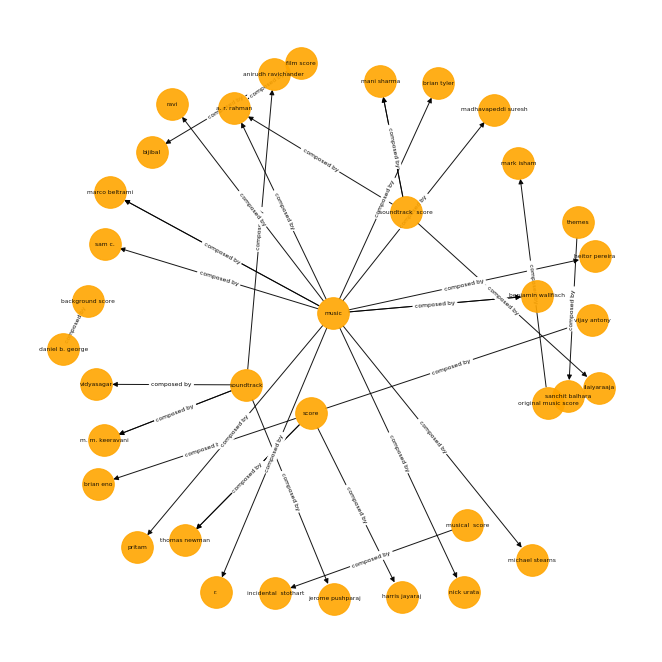

In [ ]:
plot_knowledge_graph_predicate('composed by')

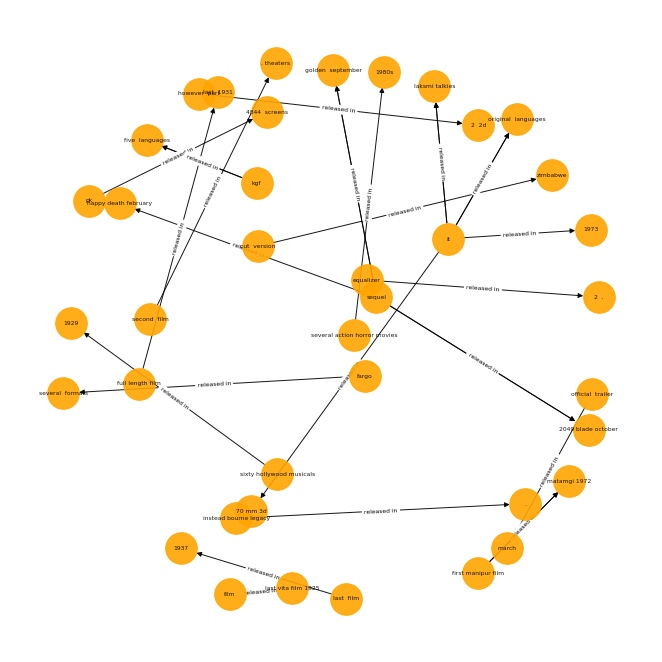

In [ ]:
plot_knowledge_graph_predicate('released in')

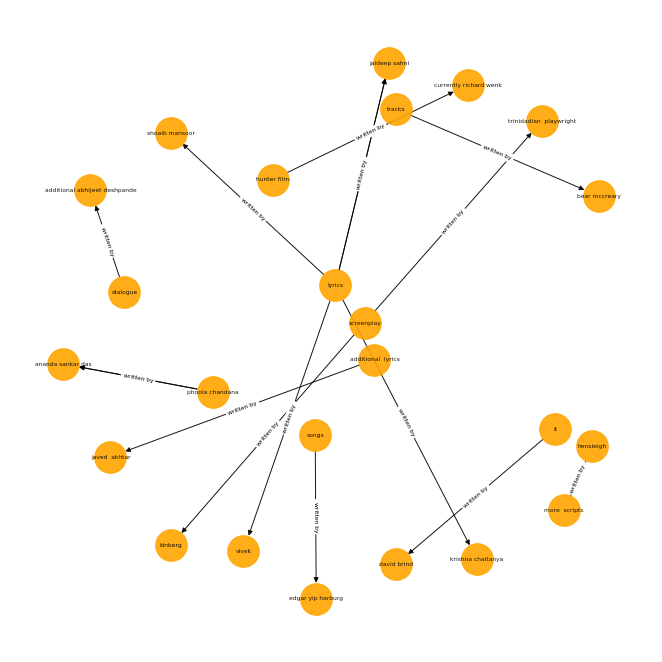

In [ ]:
plot_knowledge_graph_predicate('written by')

In [ ]:
# Function to plot the knowledge graph for a specific entity. 

def plot_knowledge_graph_entity(entity):
    G = nx.from_pandas_edgelist(kg_df[kg_df['source'] == entity], "source", "target", 
                                edge_attr = True, create_using = nx.MultiDiGraph())

    plt.figure(figsize = (9, 9))
    pos = nx.spring_layout(G, k = 0.9) 
    nx.draw(G, pos, edge_color = 'black', width = 1, linewidths = 1, node_size = 1000, font_size = 6, 
            node_color = 'skyblue', alpha = 0.9, labels = {node:node for node in G.nodes()})
    plt.show()

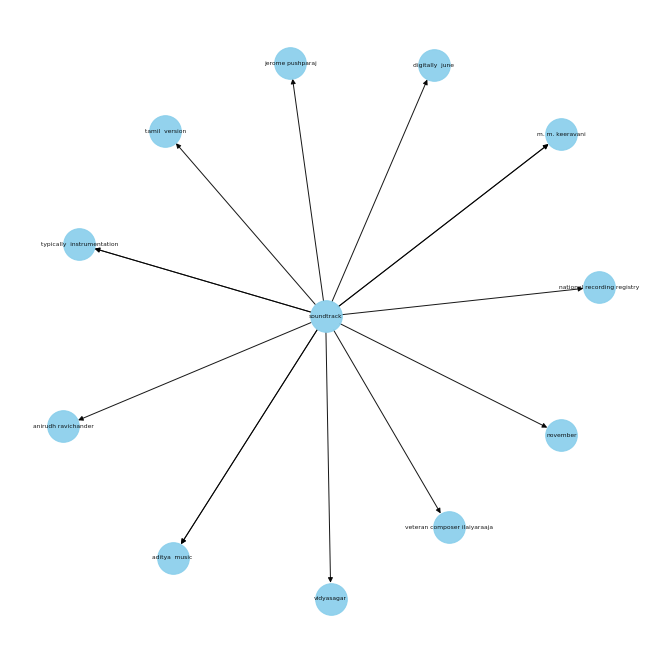

In [ ]:
plot_knowledge_graph_entity('soundtrack')